# 

# Combination of Two Machine Learning Models

1. [Libraries and Data Loading](#1)
2. [Statistics](#2)
3. [Feature Selection](#3)
4. [Feature Extration](#4)
5. [Processing Unsupervised model](#5)
6. [Processing Supervised model](#6)
7. [K-means Clustering and Artificail Neural Network](#7)
8. [Plots](#8)


## <a id="1">1. Libraries and Data Loading</a>
Pandas is managed to read the xlsx file and create two dataframes: one for traning and another for testing.<br>
All sheets from traning data are merged into one dataframe and then transformed to a spark dataframe.<br>
Similar, all sheets from test data are merged into one dataframe and then transformed to a spark dataframe.

In [55]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import ChiSqSelector, VectorAssembler, PCA, StringIndexer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import KBinsDiscretizer
import pyspark.pandas as spd
import pandas as pandi
import matplotlib.pyplot as plt
import seaborn as seab
import plotly.express as ploti
import numpy as numpi
import warnings


In [56]:

warnings.filterwarnings('ignore')

# Creating a spark session
spark = SparkSession.builder.appName('DoA').getOrCreate()

# Loading XLSX file into Pandas to create one dataframe concatenating the sheets from Train-1 to Train-10
df_pd = pandi.read_excel('./data/Project data set 1 (for reports 1 and 3) .xlsx', sheet_name=['Train-1', 'Train-2', 'Train-3', 'Train-4', 'Train-5', 'Train-6', 'Train-7', 'Train-8', 'Train-9', 'Train-10'])
df_pd = pandi.concat(df_pd.values(), ignore_index=True)

# Creating spark dataframe of training data
df_training = spark.createDataFrame(df_pd)

# Loading XLSX file into Pandas with the sheets from Test-1 to Test-5
df_pd = pandi.read_excel('./data/Project data set 1 (for reports 1 and 3) .xlsx', sheet_name=['Test-1', 'Test-2', 'Test-3', 'Test-4', 'Test-5'])
df_pd = pandi.concat(df_pd.values(), ignore_index=True)

# Creating spark dataframe of testing data
df_testing = spark.createDataFrame(df_pd)

# Printing Columns
print('\nColumn names:\n')
spark.createDataFrame(df_training.columns, 'string').show(len(df_training.columns), truncate=False)
print(f'Training dataset shape: {df_training.toPandas().shape}')
print(f'Testing dataset shape: {df_testing.toPandas().shape}')


Column names:

+-----+
|value|
+-----+
|BIS  |
|x1   |
|x2   |
|x3   |
|x4   |
|x5   |
|x6   |
|x7   |
|x8   |
+-----+

Training dataset shape: (27452, 9)
Testing dataset shape: (15185, 9)


## <a id="2">2. Statistics</a>

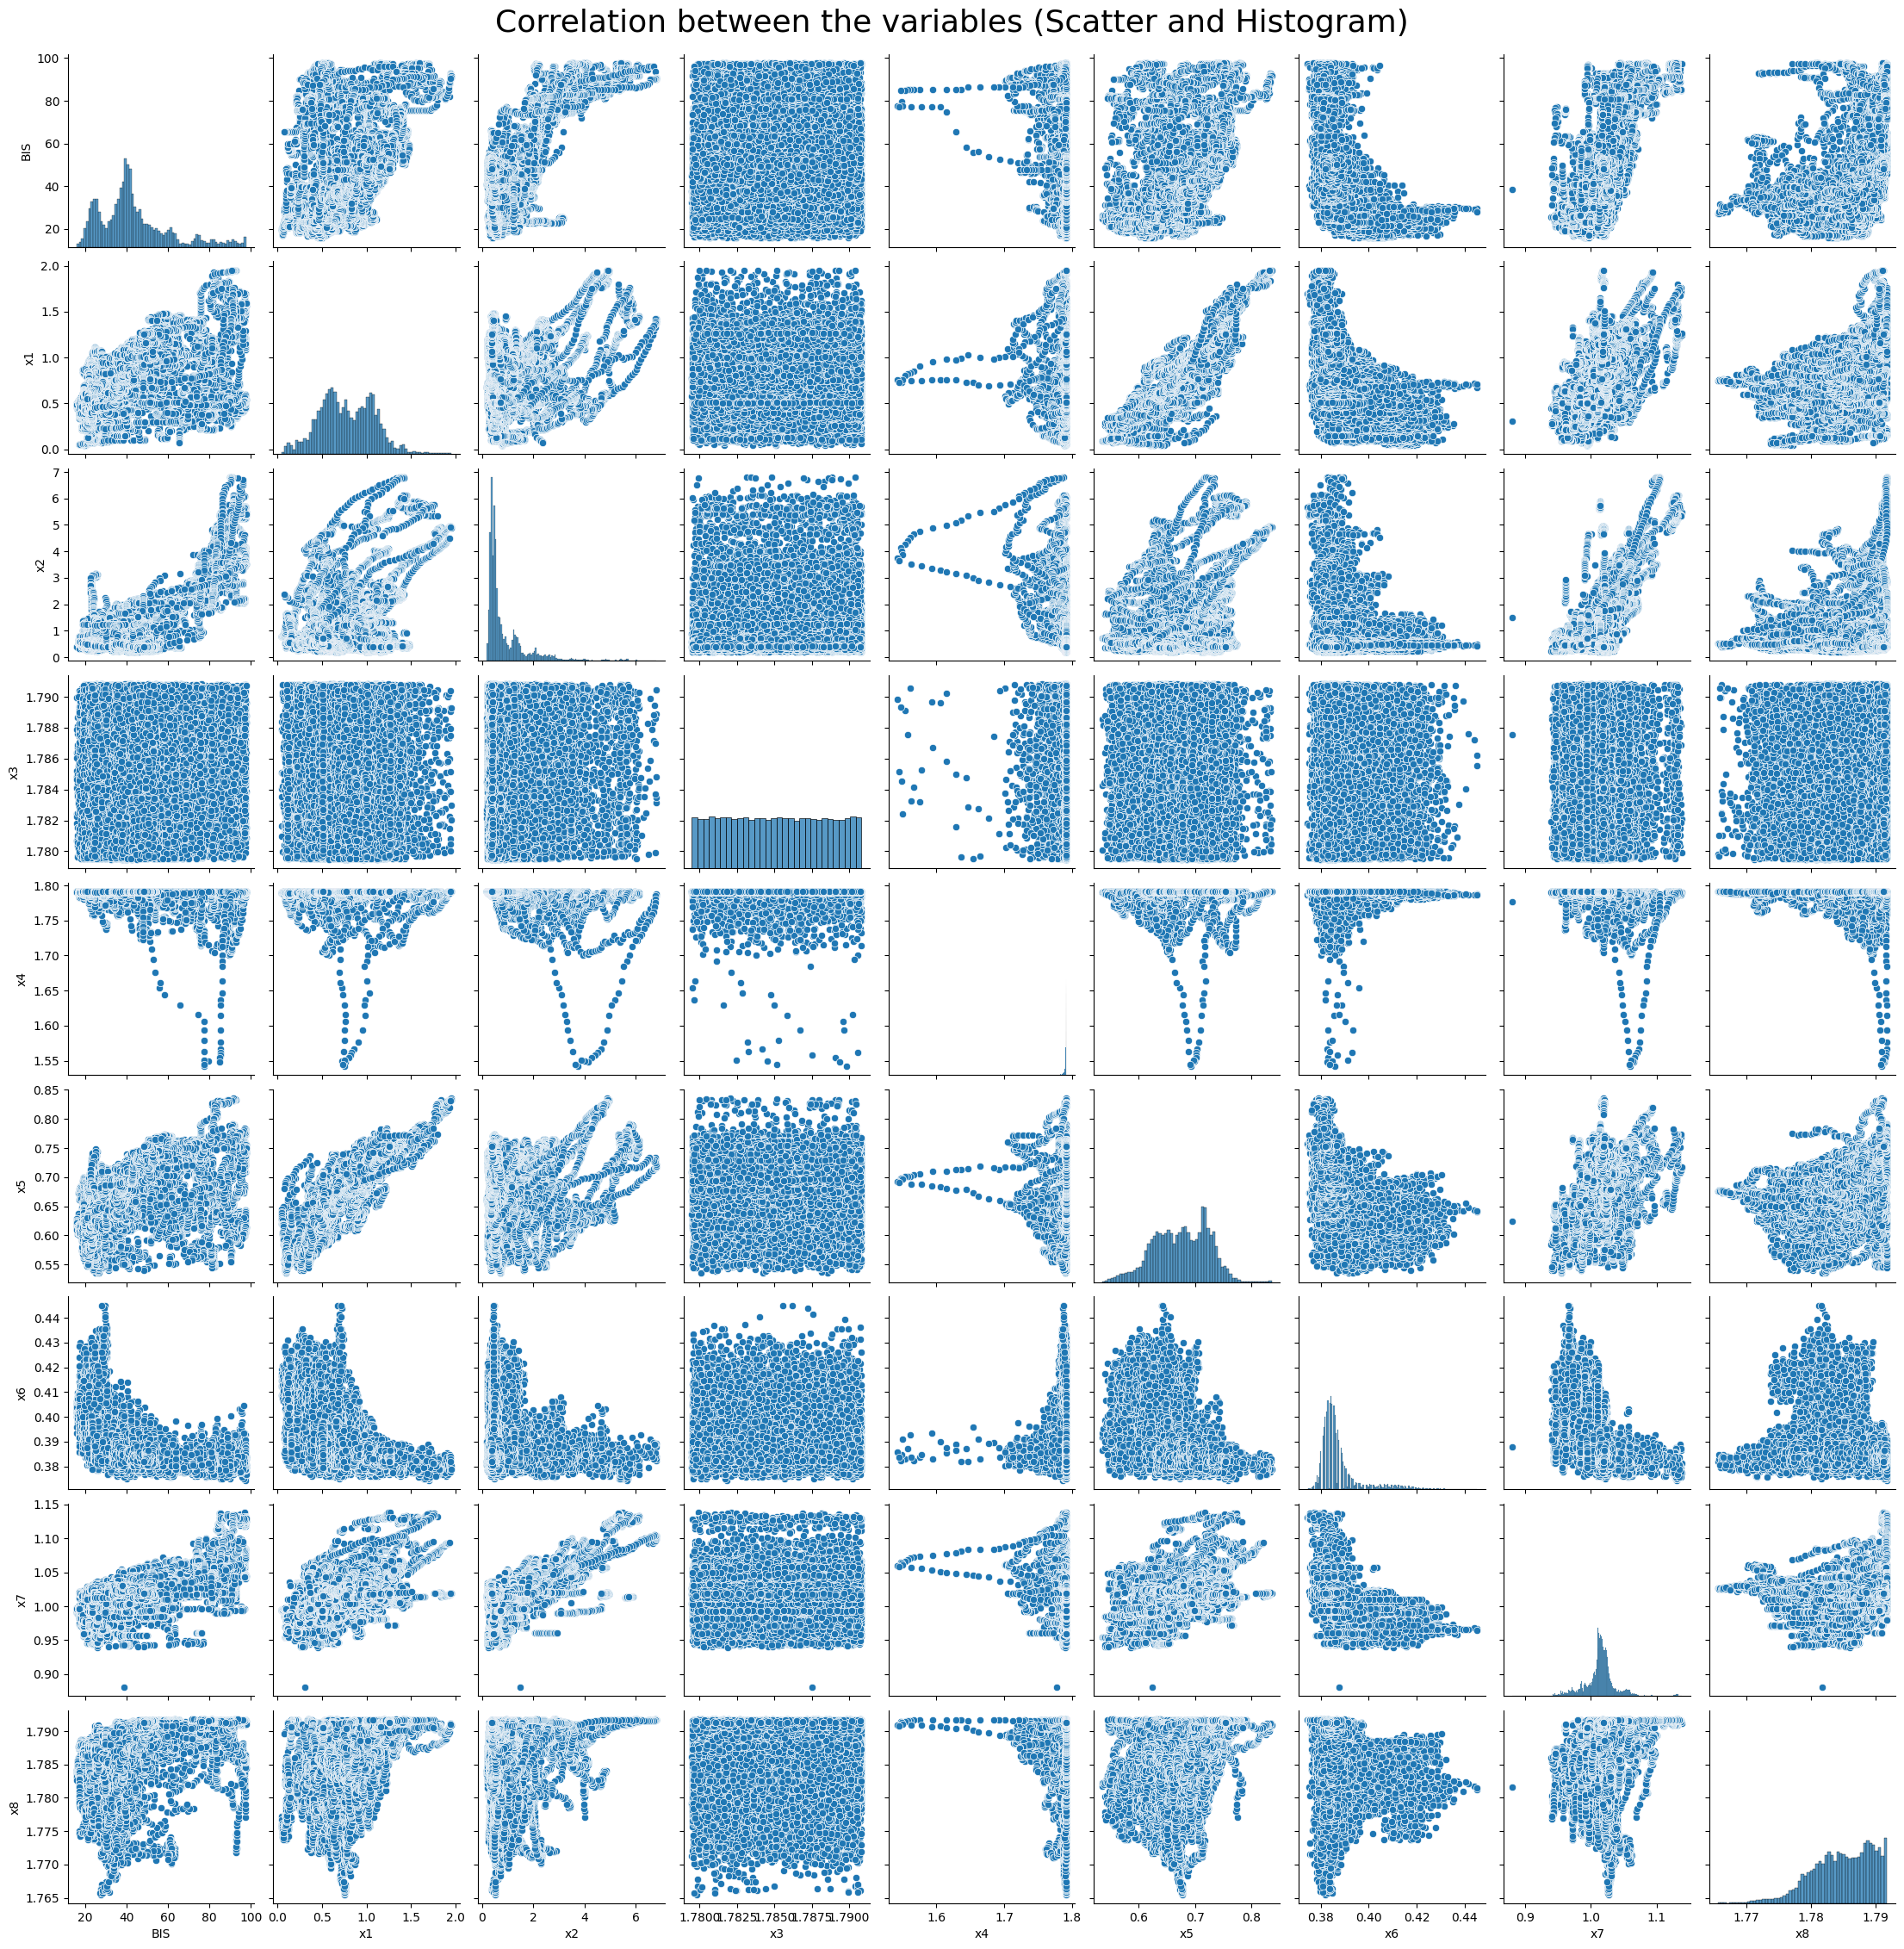

       BIS     x1     x2     x3     x4     x5     x6     x7     x8
BIS  1.000  0.474  0.744  0.008 -0.233  0.458 -0.490  0.643  0.451
x1   0.474  1.000  0.255  0.005  0.035  0.902 -0.475  0.469  0.342
x2   0.744  0.255  1.000  0.011 -0.330  0.190 -0.174  0.608  0.284
x3   0.008  0.005  0.011  1.000 -0.006  0.007  0.002  0.009  0.011
x4  -0.233  0.035 -0.330 -0.006  1.000  0.038  0.005 -0.130 -0.095
x5   0.458  0.902  0.190  0.007  0.038  1.000 -0.469  0.420  0.340
x6  -0.490 -0.475 -0.174  0.002  0.005 -0.469  1.000 -0.539 -0.116
x7   0.643  0.469  0.608  0.009 -0.130  0.420 -0.539  1.000  0.173
x8   0.451  0.342  0.284  0.011 -0.095  0.340 -0.116  0.173  1.000


In [57]:
## Generating basic statistics
df_training.drop('BIS').toPandas().describe().round(3)

# Visual correlation between variables using parplot from seaborn
seab.pairplot(df_training.toPandas())
plt.suptitle('Correlation between the variables (Scatter and Histogram)', fontsize=26, y=1.01)
plt.show()

## Generating the Correlation Matrix (Pearson Coefficient)
personCorrM = df_training.toPandas().corr(method='pearson').round(3)
print(personCorrM)

heatmap_mask = numpi.triu(numpi.ones_like(df_training.toPandas().corr(method='pearson'), dtype=bool))
heatmap_mask_cm = personCorrM.mask(heatmap_mask)

ploti_fig = ploti.imshow(heatmap_mask_cm,
                        color_continuous_scale='rdylgn',
                        text_auto=True,
                        width=700, height=700,
                        zmin=-1, zmax=1,
                        title='Correlation Matrix')
ploti_fig.show()


## <a id="3">3. Feature Selection</a>

In [90]:
## Feature Selection using Correlation Matrix (Pearson Coefficient)
# Selecting the features with correlation coefficient higher than 0.5
corr_threshold = 0.5
df_training_corr = personCorrM.drop('BIS', axis=0).drop('BIS', axis=1)
df_training_corr = df_training_corr[df_training_corr > corr_threshold].dropna(axis=0, how='all').dropna(axis=1, how='all').mask(df_training_corr == 1.0)
df_training_corr = df_training_corr.stack().reset_index()
df_training_corr.columns = ['Features 1', 'Features 2', 'Correlation Coefficient']
print('\nCorrelation Matrix:\n')
print(df_training_corr)



## Univariatee Feature Selection
# Discretise the target variable (BIS) into 350 bins
discretiser = KBinsDiscretizer(n_bins=25000, encode='ordinal', strategy='uniform')
df_training_discretised = discretiser.fit_transform(df_training.select('BIS').toPandas())

# Select the top 4 features with the highest ChiSqSelector score
selectkbest = SelectKBest(score_func=chi2, k=4)
selectkbest.fit(df_training.drop('BIS').toPandas(), df_training_discretised)
df_training_univ = selectkbest.transform(df_training.drop('BIS').toPandas()).astype('float64')
df_training_univ_names = df_training.drop('BIS').toPandas().columns.values[selectkbest.get_support()]
df_training_univ_fs = pandi.DataFrame(df_training_univ, columns=df_training_univ_names)
df_training_univ_fs = spark.createDataFrame(df_training_univ_fs)
print('\nSelectKBest features:\n')
df_training_univ_fs.show()







Correlation Matrix:

  Features 1 Features 2  Correlation Coefficient
0         x1         x5                    0.902
1         x2         x7                    0.608
2         x5         x1                    0.902
3         x7         x2                    0.608

SelectKBest features:

+-----------------+----------------+-----------------+----------------+
|               x1|              x2|               x5|              x7|
+-----------------+----------------+-----------------+----------------+
|0.689160187270101|3.64386314176022|0.656469114887491|1.03102649679135|
| 0.70484486028392|3.63699368096882|0.661085331656252|1.03106469379857|
|0.710990273948176|3.64553425332286|0.664866605883735|1.03123426164549|
|0.715936033306433| 3.6550048670845|0.664222583974326|1.03141904024025|
|0.716480453208565|3.65629923961093|0.665575179588388|1.03160328531594|
|0.717686256459125|3.64998612905539|0.666548273732746|1.03166733082859|
|0.667323973547175|3.65516300165066|0.662356061786237|1.03179

## <a id="4">4. Feature Extration</a>